# DiploDatos 2019 - Análisis de Series Temporales

## Integrantes

| Nombre | e-mail |
|------|------|
|Rivadero, Isabel | isarivadero@hotmail.com |
|Vargas, Miguel | lvc0107@protonmail.com |
|Mancuso, Fernando | manquius@gmail.com |

## Práctico de Introducción al aprendizaje automático

En este práctico no introduciremos en las primeras herramientas de aprendizaje
automático. Diseñaremos e implementaremos algunos modelos simples y definir métricas
para ver como performan.

### Dataset

In [2]:
### Aumentar el ancho del notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(rc={'figure.figsize':(10,6)})

cols = ['service',
        'sender_zipcode',
        'receiver_zipcode',
        'sender_state',
        'receiver_state',
        'shipment_type',
        'quantity',
        'status',
        'date_created',
        'date_sent',
        'date_visit',
        'target']
cols_holidays = ['holiday', 
                 'description']
data_path = './shipments_BR_201903.csv'
holidays = './holidays.csv'

#### Referencia de las columnas
* **service**: Identificador unico que corresponde a un tipo de servicio de un correo en particular.
* **sender_zipcode:** Código postal de quien envía el paquete (usualmente el vendedor).
* **receiver_zipcode:** Código postal de quien recibe el paquete (usualmente el comprador).
* **sender_state:** Nombre abreviado del estado de quien envía el paquete.
* **receiver_state:** Nombre abreviado del estado de quien recibe el paquete.
* **quantity:** Cantidad de items que tiene dentro el paquete.
* **status:** Estado final del envío.
* **date_created:** Fecha de compra de el o los items.
* **date_sent:** Fecha en que el correo recibe el paquete.
* **date_visit:** Fecha en que el correo entrega el paquete.
* **target:** Cantidad de dias hábiles que tardó el correo en entregar el paquete desde que lo recibe.


In [5]:
df = pd.read_csv(data_path, usecols=cols)
df.shape

(1000000, 12)

In [6]:
df.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
1,SP,17052,MG,37750,standard,1,1,done,2019-03-19 00:00:00,2019-03-20 14:44:00,2019-03-27 10:21:00,5
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
4,SP,4361,RS,96810,express,1,0,done,2019-03-08 00:00:00,2019-03-12 08:19:00,2019-03-16 08:24:00,4


In [7]:
# set seed for reproducibility
np.random.seed(0)

**Eliminamos datos inconsistentes:**

Aplicamos curacion y limpieza de datos

In [8]:
df_clean = df[(df['date_sent'] <= df['date_visit']) & (df['date_created'] <= df['date_sent']) & (df['date_created'] <= df['date_visit'])].copy()
df.shape

(1000000, 12)

**Removemos outliers.**

In [10]:
df_clean = df_clean[df_clean['target'] < 23].copy()
df_clean.shape

(990370, 12)

####  Implementación
Solo vamos a diferenciar dos tipos de envíos:
​ rápidos: un envío es rápido si llega antes de 3 días hábiles 
​ y lentos: si llega después de 3 días hábiles.
Esto nos reduce los problemas de clasificación a solo 2 clases.

In [12]:
df.sample(5)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
157105,SP,14405,MG,37706,standard,2,3,done,2019-03-13 00:00:00,2019-03-19 20:52:00,2019-03-22 11:00:00,3
374554,BA,40260,SE,49088,standard,1,1,done,2019-03-04 00:00:00,2019-03-06 15:32:00,2019-03-23 11:23:00,12
688694,SP,8061,DF,70236,express,1,0,done,2019-03-15 00:00:00,2019-03-15 16:04:00,2019-03-18 12:00:00,1
265381,SP,3118,BA,48455,standard,3,1,done,2019-03-10 00:00:00,2019-03-11 14:58:00,2019-03-27 07:56:00,12
955415,SP,14402,DF,71503,standard,1,4,done,2019-03-01 00:00:00,2019-03-07 03:55:36,2019-03-11 16:39:00,1


In [13]:
df.dtypes

sender_state        object
sender_zipcode       int64
receiver_state      object
receiver_zipcode     int64
shipment_type       object
quantity             int64
service              int64
status              object
date_created        object
date_sent           object
date_visit          object
target               int64
dtype: object

In [14]:
df.describe()

,sender_zipcode,receiver_zipcode,quantity,service,target
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,22637.975896,41650.306365,1.277814,1.182677,6.021577
std,27817.028435,30952.352631,0.661583,1.486557,5.157973
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,4836.000000,13465.000000,1.000000,0.000000,2.000000
50%,12091.000000,35164.000000,1.000000,1.000000,4.000000
75%,23050.000000,72308.000000,1.000000,1.000000,9.000000
max,99990.000000,99990.000000,5.000000,11.000000,118.000000


####  Implementación
Solo vamos a diferenciar dos tipos de envíos:
​ rápidos: un envío es rápido si llega antes de 3 días hábiles 
​ y lentos: si llega después de 3 días hábiles.
Esto nos reduce los problemas de clasificación a solo 2 clases.


#### Definiciones básicas:
1- Definir una métrica binaria para evaluar los modelos



In [ ]:
# defino una metrica
def metrica(calculado, real):
    cont = 0
    for i in range(len(real)):
        if (calculado[i] == real[i]):
            cont +=1
    
    return cont/len(real)

2- Diseñar un modelo -baseline- para los envíos de SP a SP, como el modelo más
simple posible. Para esto no necesitamos machine learning, solo proponer una
heurística a partir de los datos observados en los prácticos de análisis


In [12]:
sp_sp = df_clean[(df_clean['sender_state'] == 'SP') & (df_clean['receiver_state'] == 'SP')]
sp_sp.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,target
0,SP,3005,SP,5409,express,1,0,done,2019-03-04 00:00:00,2019-03-05 13:24:00,2019-03-07 18:01:00,2
2,SP,2033,SP,11040,express,1,0,done,2019-02-18 00:00:00,2019-02-21 15:08:00,2019-02-28 18:19:00,5
3,SP,13900,SP,18500,express,1,0,done,2019-03-09 00:00:00,2019-03-11 15:48:00,2019-03-12 13:33:00,1
8,SP,2313,SP,4165,express,2,0,done,2019-02-28 00:00:00,2019-03-01 14:35:00,2019-03-04 14:22:00,1
10,SP,11015,SP,15025,express,2,3,done,2019-02-24 00:00:00,2019-03-04 23:54:00,2019-03-11 22:00:00,4


In [13]:
sp_sp.shape

(278081, 12)

In [14]:
# but it couldnt be useful for you depending on your approach)
from sklearn.model_selection import train_test_split


# División entre instancias y etiquetas
X = sp_sp.drop('target', axis=1)
y = sp_sp['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit
776089,SP,18010,SP,5712,express,1,0,done,2019-03-19 00:00:00,2019-03-20 17:03:00,2019-03-22 12:05:00
383341,SP,18150,SP,6775,standard,2,1,done,2019-03-06 00:00:00,2019-03-07 14:17:00,2019-03-16 10:35:00
893527,SP,6422,SP,16290,express,1,0,done,2019-03-11 00:00:00,2019-03-13 00:09:27,2019-03-18 15:41:00
746617,SP,6622,SP,11740,standard,1,1,done,2019-03-04 00:00:00,2019-03-06 10:53:00,2019-03-12 12:32:00
696614,SP,13324,SP,5763,express,1,0,done,2019-03-24 00:00:00,2019-03-25 14:37:00,2019-03-26 18:42:00


In [16]:
X_train.shape

(222464, 11)

In [17]:
y_train.head()

776089    2
383341    6
893527    3
746617    3
696614    1
Name: target, dtype: int64

In [18]:
y_train.shape

(222464,)

In [19]:
X_test.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit
68262,SP,15800,SP,13304,express,1,0,done,2019-03-04 00:00:00,2019-03-07 19:15:30,2019-03-11 17:36:00
269933,SP,12232,SP,12237,express,1,0,done,2019-03-07 00:00:00,2019-03-08 15:40:00,2019-03-11 12:40:00
206944,SP,1009,SP,6852,express,1,0,done,2019-02-24 00:00:00,2019-02-25 11:13:00,2019-03-06 12:40:00
422707,SP,9890,SP,13974,standard,1,3,done,2019-03-04 00:00:00,2019-03-07 04:32:00,2019-03-12 14:00:00
415678,SP,4764,SP,13940,standard,1,2,done,2019-02-21 00:00:00,2019-02-26 23:24:11,2019-02-28 12:24:00


In [20]:
X_test.shape

(55617, 11)

3- Calcular la métrica y la matriz de confusión para el baseline

#### Preparación de los features:
4- Con la intención de salvar las rutas poco representadas, implementar una codificación para los features:  sender_zipcode y  receiver_zipcode



5- Seleccionar un conjunto de features para entrenar modelos de machine learning

In [27]:
df_clean.corr(method=  'pearson')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.102486,0.001460,-0.125616,0.167725
receiver_zipcode,0.102486,1.000000,-0.000603,0.006570,0.375070
quantity,0.001460,-0.000603,1.000000,-0.000769,-0.000437
service,-0.125616,0.006570,-0.000769,1.000000,-0.078810
target,0.167725,0.375070,-0.000437,-0.078810,1.000000


In [28]:
df_clean.corr(method=  'kendall')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.063768,0.000968,0.018325,0.152912
receiver_zipcode,0.063768,1.000000,-0.000695,0.147060,0.321561
quantity,0.000968,-0.000695,1.000000,-0.001050,-0.000887
service,0.018325,0.147060,-0.001050,1.000000,0.214300
target,0.152912,0.321561,-0.000887,0.214300,1.000000


In [29]:
df_clean.corr(method=  'spearman')

,sender_zipcode,receiver_zipcode,quantity,service,target
sender_zipcode,1.000000,0.093986,0.001211,0.027504,0.221166
receiver_zipcode,0.093986,1.000000,-0.000870,0.192363,0.448123
quantity,0.001211,-0.000870,1.000000,-0.001145,-0.001067
service,0.027504,0.192363,-0.001145,1.000000,0.282425
target,0.221166,0.448123,-0.001067,0.282425,1.000000


Segun estos tres metodos quantity no guarda una relacion importante con target, por lo tanto no lo tendremos en cuenta

#### Clustering:
6- Clusterizar los envíos basados únicamente en las rutas. Para esto recomiendo utilizar KMeans


In [31]:
from sklearn.cluster import KMeans



In [33]:
X_train.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit'],
      dtype='object')

In [35]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train.drop(['sender_state', 'receiver_state', 'shipment_type', 'quantity', 'status', 'date_created', 'date_sent', 'date_visit'], axis=1))


In [40]:
kmeans.cluster_centers_

array([[7.56955663e+03, 5.42858462e+03, 1.49819511e+00],
       [8.76527014e+03, 1.43379340e+04, 9.69533716e-01]])

7- (*) Cual es el número óptimo de clusters? (Ver método de ​ Elbow​ con KMeans)


In [37]:
 kmeanModel.fit(X).cluster_value_

NameError: name 'kmeanModel' is not defined

In [24]:
KMeans(n_clusters=k).fit(X).cluster_centers_

array([[8.55182515e+04, 8.33143770e+04, 7.20237692e-01],
       [8.41969892e+03, 1.07789333e+04, 1.23925588e+00],
       [8.84435674e+03, 6.51602317e+04, 1.33807573e+00],
       [8.49944952e+04, 1.27504627e+04, 7.97315648e-01],
       [8.76602021e+03, 3.50946594e+04, 1.39455269e+00],
       [8.38848402e+04, 4.15744592e+04, 9.39322586e-01],
       [8.80369636e+03, 8.79665361e+04, 1.38153312e+00],
       [3.61138449e+04, 7.69602121e+04, 9.09335727e-01],
       [3.29936037e+04, 2.39154867e+04, 6.51287175e-01]])

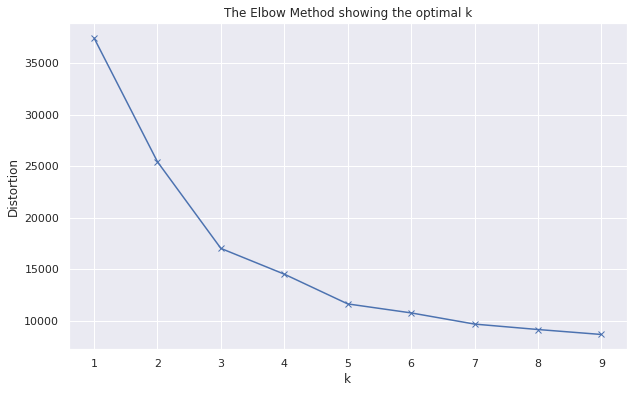

In [21]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
plt.plot()
X = df[['sender_zipcode', 'receiver_zipcode', 'service']]
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


8- Describir brevemente las características interesante de los clusters


#### Modelos lineales:
9- Leer sobre accuracy, precision y recall para agregarlas al pool de métricas que vamos a utilizar.


10- Implementar un modelo basado en regresión lineal, calcular las métricas y la matriz de confusión


11- Implementar un modelo basado en regresión logística, calcular las métricas y la matriz de confusión


12- Cual es la principal diferencia entre estos modelos? Tuviste que hacer algún tipo de post-procesamiento?


13- Estandarizar los features seleccionados y re entrenar los modelos. Las métricas
mejoran? Explicar por qué.
